In [3]:
# Import required libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, sum, count, avg, when, dayofweek, month
from pyspark.ml.feature import VectorAssembler, MinMaxScaler, StringIndexer, OneHotEncoder
from pyspark.ml.classification import RandomForestClassifier, LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from sklearn.metrics import confusion_matrix, classification_report

# Initialize Spark session
spark = SparkSession.builder \
    .appName("Classification_Task") \
    .config("spark.executor.memory", "2g") \
    .config("spark.driver.memory", "2g") \
    .config("spark.local.dir", "E:/SparkTemp") \
    .getOrCreate()

# Load Dataset from Local File System
data_path = r"C:\\hadoop_doc\\Online_Retail.csv"
df = spark.read.csv(data_path, header=True, inferSchema=True)



In [ ]:
# Data Cleaning and Feature Engineering
df = df.dropna().filter(col("Quantity") > 0).filter(col("UnitPrice") > 0)
df = df.withColumn("TotalAmount", col("Quantity") * col("UnitPrice"))

# Compute total spend per customer
spending_df = df.groupBy("CustomerID").agg(sum("TotalAmount").alias("Total_Spend"))
median_spend = spending_df.approxQuantile("Total_Spend", [0.5], 0.0)[0]
spending_df = spending_df.withColumn("HighValueCustomer", when(col("Total_Spend") > median_spend, 1).otherwise(0))

# Compute features for model training
customer_features = df.groupBy("CustomerID").agg(
    count("InvoiceNo").alias("Purchase_Frequency"),
    avg("TotalAmount").alias("Avg_Order_Value")
)

df = df.withColumn("Purchase_Day", dayofweek(col("InvoiceDate")))
df = df.withColumn("Purchase_Month", month(col("InvoiceDate")))

time_features = df.groupBy("CustomerID").agg(
    avg("Purchase_Day").alias("Avg_Purchase_Day"),
    avg("Purchase_Month").alias("Avg_Purchase_Month")
)
customer_features = customer_features.join(time_features, on="CustomerID", how="inner")



In [ ]:
# Merge features with target label
customer_df = customer_features.join(spending_df, on="CustomerID", how="inner")

# Feature Engineering
feature_cols = ["Purchase_Frequency", "Avg_Order_Value", "Avg_Purchase_Day"]
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
customer_df = assembler.transform(customer_df)



In [ ]:
# Train-Test Split
train_df, test_df = customer_df.randomSplit([0.8, 0.2], seed=42)



In [ ]:
# Feature Scaling
scaler = MinMaxScaler(inputCol="features", outputCol="scaledFeatures")
scaler_model = scaler.fit(train_df)
train_df = scaler_model.transform(train_df)
test_df = scaler_model.transform(test_df)

In [ ]:
# Hyperparameter tuning with Cross Validation
rf_classifier = RandomForestClassifier(labelCol="HighValueCustomer", featuresCol="scaledFeatures")
param_grid = (ParamGridBuilder()
              .addGrid(rf_classifier.numTrees, [10, 20])  # Reduced tree options
              .addGrid(rf_classifier.maxDepth, [5, 10])  # Reduced depth options
              .build())

In [ ]:

evaluator = MulticlassClassificationEvaluator(labelCol="HighValueCustomer", metricName="accuracy")
cross_validator = CrossValidator(estimator=rf_classifier,
                                 estimatorParamMaps=param_grid,
                                 evaluator=evaluator,
                                 numFolds=5)

In [4]:
cv_model = cross_validator.fit(train_df)
best_model = cv_model.bestModel
rf_predictions = best_model.transform(test_df)
rf_accuracy = evaluator.evaluate(rf_predictions)

print(f"Random Forest Accuracy after Cross-Validation: {rf_accuracy:.4f}")

Random Forest Accuracy after Cross-Validation: 0.9695


In [5]:
# Train and Evaluate Logistic Regression Model
lr_classifier = LogisticRegression(labelCol="HighValueCustomer", featuresCol="scaledFeatures")
lr_model = lr_classifier.fit(train_df)
lr_predictions = lr_model.transform(test_df)
lr_accuracy = evaluator.evaluate(lr_predictions)

print(f"Logistic Regression Accuracy: {lr_accuracy:.4f}")


Logistic Regression Accuracy: 0.8331


In [6]:
# Compute Classification Reports
rf_predictions_pandas = rf_predictions.select("HighValueCustomer", "prediction").toPandas()
lr_predictions_pandas = lr_predictions.select("HighValueCustomer", "prediction").toPandas()

rf_classification_report = classification_report(rf_predictions_pandas["HighValueCustomer"], rf_predictions_pandas["prediction"])
print("Random Forest - Classification Report:\n", rf_classification_report)

lr_classification_report = classification_report(lr_predictions_pandas["HighValueCustomer"], lr_predictions_pandas["prediction"])
print("Logistic Regression - Classification Report:\n", lr_classification_report)

# Compute and Display Confusion Matrices
rf_conf_matrix = confusion_matrix(rf_predictions_pandas["HighValueCustomer"], rf_predictions_pandas["prediction"])
lr_conf_matrix = confusion_matrix(lr_predictions_pandas["HighValueCustomer"], lr_predictions_pandas["prediction"])

print("Random Forest - Confusion Matrix:\n", rf_conf_matrix)
print("Logistic Regression - Confusion Matrix:\n", lr_conf_matrix)

# Stop Spark Session
spark.stop()

Random Forest - Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.96      0.97       425
           1       0.96      0.97      0.97       396

    accuracy                           0.97       821
   macro avg       0.97      0.97      0.97       821
weighted avg       0.97      0.97      0.97       821

Logistic Regression - Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.89      0.85       425
           1       0.87      0.77      0.82       396

    accuracy                           0.83       821
   macro avg       0.84      0.83      0.83       821
weighted avg       0.84      0.83      0.83       821

Random Forest - Confusion Matrix:
 [[410  15]
 [ 10 386]]
Logistic Regression - Confusion Matrix:
 [[379  46]
 [ 91 305]]


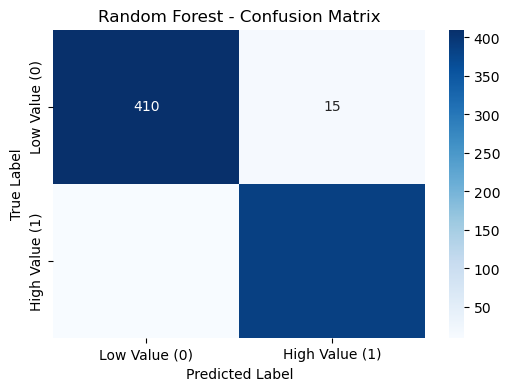

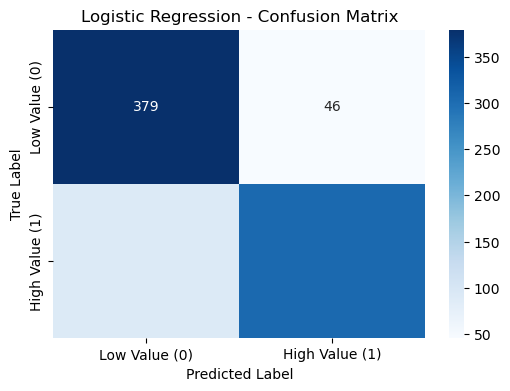

In [7]:
# Compute and Display Confusion Matrices
rf_conf_matrix = confusion_matrix(rf_predictions_pandas["HighValueCustomer"], rf_predictions_pandas["prediction"])
lr_conf_matrix = confusion_matrix(lr_predictions_pandas["HighValueCustomer"], lr_predictions_pandas["prediction"])

plt.figure(figsize=(6, 4))
sns.heatmap(rf_conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Low Value (0)", "High Value (1)"],
            yticklabels=["Low Value (0)", "High Value (1)"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Random Forest - Confusion Matrix")
plt.show()

plt.figure(figsize=(6, 4))
sns.heatmap(lr_conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Low Value (0)", "High Value (1)"],
            yticklabels=["Low Value (0)", "High Value (1)"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Logistic Regression - Confusion Matrix")
plt.show()

# Stop Spark Session
spark.stop()

In [ ]:





# Compute Classification Reports
from sklearn.metrics import classification_report
rf_predictions_pandas = rf_predictions.select("HighValueCustomer", "prediction").toPandas()
lr_predictions_pandas = lr_predictions.select("HighValueCustomer", "prediction").toPandas()

rf_classification_report = classification_report(rf_predictions_pandas["HighValueCustomer"], rf_predictions_pandas["prediction"])
print("Random Forest - Classification Report:\n", rf_classification_report)

lr_classification_report = classification_report(lr_predictions_pandas["HighValueCustomer"], lr_predictions_pandas["prediction"])
print("Logistic Regression - Classification Report:\n", lr_classification_report)

# Stop Spark Session
spark.stop()
